In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built wrapt absl-py termcolor gast


ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [3]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [39]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers.normalization import BatchNormalization

## Load data and do data normalization

In [2]:
df = pd.read_csv('Options_R_new.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,realized_vol,underlying_price,interest_rate,cp_flag_C,cp_flag_P
0,AXP,2012-09-04,2012-09-07,3,55.0,3.65,0.346417,0.169029,58.61,0.001,1,0
1,AXP,2012-09-04,2012-09-07,3,57.5,1.25,0.234645,0.169029,58.61,0.001,1,0
2,AXP,2012-09-04,2012-09-07,3,60.0,0.09,0.229130,0.169029,58.61,0.001,1,0
3,AXP,2012-09-04,2012-09-07,3,62.5,0.08,0.413285,0.169029,58.61,0.001,1,0
4,AXP,2012-09-04,2012-09-07,3,65.0,0.08,0.608310,0.169029,58.61,0.001,1,0


In [3]:
# Remove the option data has less than 7 days to maturity.
df = df[df.maturity > 6]

# Remove the option data with deep in-the-money and deep out-of-money
def moneyness(S,X):
    return S/X
df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
df = df[df.moneyness >= 0.7]
df = df[df.moneyness <= 1.2]

In [23]:
df = df[df['interest_rate'].notnull()]
y = df['best_offer'].values
X = df[['maturity', 'strike_price', 'impl_volatility', 'underlying_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

In [24]:
# Normalize the data to build a regression neural network model
X = preprocessing.normalize(X)
y = y.reshape(-1,1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(X_train.shape)
print(y_train.shape)

(1138934, 7)
(1138934, 1)


In [28]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [29]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

In [30]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

In [31]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [32]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

In [33]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 911147 samples, validate on 227787 samples
Epoch 1/200
911147/911147 [==============================] - 5s 5us/step - loss: 40.2112 - rmse: 3.5875 - r_square: 0.5739 - val_loss: 6.7470 - val_rmse: 1.5053 - val_r_square: 0.9275
Epoch 2/200
911147/911147 [==============================] - 5s 5us/step - loss: 4.3188 - rmse: 1.1751 - r_square: 0.9534 - val_loss: 2.4260 - val_rmse: 0.9224 - val_r_square: 0.9739
Epoch 3/200
911147/911147 [==============================] - 5s 5us/step - loss: 2.0073 - rmse: 0.8025 - r_square: 0.9782 - val_loss: 1.2903 - val_rmse: 0.6522 - val_r_square: 0.9861
Epoch 4/200
911147/911147 [==============================] - 5s 5us/step - loss: 1.2870 - rmse: 0.6475 - r_square: 0.9861 - val_loss: 2.3249 - val_rmse: 0.9078 - val_r_square: 0.9750
Epoch 5/200
911147/911147 [==============================] - 4s 5us/step - loss: 1.0497 - rmse: 0.5807 - r_square: 0.9887 - val_loss: 0.7164 - val_rmse: 0.5116 - val_r_square: 0.9923
Epoch 6/200
911147/911147 [=====

911147/911147 [==============================] - 4s 5us/step - loss: 0.1589 - rmse: 0.2189 - r_square: 0.9983 - val_loss: 0.1218 - val_rmse: 0.1976 - val_r_square: 0.9987
Epoch 00089: early stopping


In [38]:
model.save('model13.h5')

In [34]:
predictions = model.predict(X_test)
print(predictions[:10])

[[ 8.988133  ]
 [ 0.16768476]
 [24.407785  ]
 [ 0.06328553]
 [ 6.2233644 ]
 [ 1.0276563 ]
 [ 6.978905  ]
 [ 0.06013948]
 [ 1.1953082 ]
 [ 9.010826  ]]


In [16]:
y_test[:10]

array([[ 9.1 ],
       [ 0.14],
       [25.4 ],
       [ 0.04],
       [ 6.05],
       [ 1.01],
       [ 6.75],
       [ 0.04],
       [ 1.13],
       [ 9.05]])

## Plot learning curves including R^2 and RMSE

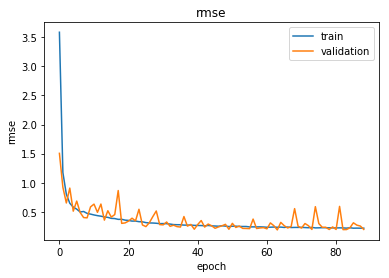

In [35]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

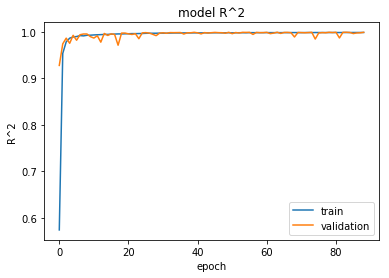

In [36]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [37]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions))



Mean absolute error (MAE):      0.199007
Mean squared error (MSE):       0.123450
Root mean squared error (RMSE): 0.351355
R square (R^2):                 0.998734


## Try batch normalization technique to regularize neurons

In [40]:
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 911147 samples, validate on 227787 samples
Epoch 1/200
911147/911147 [==============================] - 5s 6us/step - loss: 12.4884 - rmse: 1.6176 - r_square: 0.8677 - val_loss: 5.5381 - val_rmse: 0.9780 - val_r_square: 0.9411
Epoch 2/200
911147/911147 [==============================] - 5s 6us/step - loss: 3.6827 - rmse: 0.9593 - r_square: 0.9603 - val_loss: 1.4782 - val_rmse: 0.6185 - val_r_square: 0.9842
Epoch 3/200
911147/911147 [==============================] - 5s 5us/step - loss: 3.3184 - rmse: 0.9046 - r_square: 0.9642 - val_loss: 1.1629 - val_rmse: 0.6006 - val_r_square: 0.9875
Epoch 4/200
911147/911147 [==============================] - 5s 5us/step - loss: 3.1695 - rmse: 0.8670 - r_square: 0.9658 - val_loss: 1.1002 - val_rmse: 0.5689 - val_r_square: 0.9882
Epoch 5/200
911147/911147 [==============================] - 5s 5us/step - loss: 3.1751 - rmse: 0.8643 - r_square: 0.9658 - val_loss: 1.3035 - val_rmse: 0.6099 - val_r_square: 0.9860
Epoch 6/200
911147/911147 [=====

In [41]:
predictions3 = model3.predict(X_test)
print(predictions3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_test,predictions3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_test,predictions3))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_test,predictions3)))
print("R square (R^2):                 %f" % skm.r2_score(y_test,predictions3))

[[ 8.7645283e+00]
 [ 1.7856395e-01]
 [ 2.4396765e+01]
 [-1.6550899e-02]
 [ 6.1647387e+00]
 [ 9.1036761e-01]
 [ 6.8106346e+00]
 [ 9.2254996e-02]
 [ 1.0353720e+00]
 [ 6.9386244e+00]]


Mean absolute error (MAE):      0.386960
Mean squared error (MSE):       0.673518
Root mean squared error (RMSE): 0.820682
R square (R^2):                 0.993094


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>